In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

base_path = "/content/drive/MyDrive"
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".json"):
            print(os.path.join(root, file))


/content/drive/MyDrive/Copy of user-wallet-transactions.json
/content/drive/MyDrive/AaveAssignment/user-wallet-transactions.json


In [18]:
import json

file_path = "/content/drive/MyDrive/AaveAssignment/user-wallet-transactions.json"

with open(file_path, "r") as f:
    data = json.load(f)

print(f"Total transactions: {len(data)}")
print("Sample transaction:\n")
print(json.dumps(data[0], indent=2))


Total transactions: 100000
Sample transaction:

{
  "_id": {
    "$oid": "681d38fed63812d4655f571a"
  },
  "userWallet": "0x00000000001accfa9cef68cf5371a23025b6d4b6",
  "network": "polygon",
  "protocol": "aave_v2",
  "txHash": "0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190",
  "logId": "0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190_Deposit",
  "timestamp": 1629178166,
  "blockNumber": 1629178166,
  "action": "deposit",
  "actionData": {
    "type": "Deposit",
    "amount": "2000000000",
    "assetSymbol": "USDC",
    "assetPriceUSD": "0.9938318274296357543568636362026045",
    "poolId": "0x2791bca1f2de4661ed88a30c99a7a9449aa84174",
    "userId": "0x00000000001accfa9cef68cf5371a23025b6d4b6"
  },
  "__v": 0,
  "createdAt": {
    "$date": "2025-05-08T23:06:39.465Z"
  },
  "updatedAt": {
    "$date": "2025-05-08T23:06:39.465Z"
  }
}


In [7]:
from collections import defaultdict

wallet_dict = defaultdict(list)

for tx in data:
    wallet = tx.get("userWallet")
    if wallet:
        wallet_dict[wallet].append(tx)

print(f"Total unique wallets: {len(wallet_dict)}")

# Show sample transactions for the first wallet
first_wallet = list(wallet_dict.keys())[0]
print(f"\nSample transactions for {first_wallet}:\n")
for tx in wallet_dict[first_wallet][:3]:
    print(f"{tx['action']} → {tx['actionData'].get('amount')} {tx['actionData'].get('assetSymbol')}")


Total unique wallets: 3497

Sample transactions for 0x00000000001accfa9cef68cf5371a23025b6d4b6:

deposit → 2000000000 USDC


In [8]:
import pandas as pd

def safe_float(x):
    try:
        return float(x)
    except:
        return 0.0

features = []

for wallet, txs in wallet_dict.items():
    deposit_usd = 0
    borrow_usd = 0
    repay_usd = 0
    liquidation_count = 0

    for tx in txs:
        action = tx.get("action", "").lower()
        data = tx.get("actionData", {})

        # Get price and amount
        amount = safe_float(data.get("amount"))
        price = safe_float(data.get("assetPriceUSD"))
        amount_usd = amount * price / (10 ** 6)  # Normalize USDC decimals

        if action == "deposit":
            deposit_usd += amount_usd
        elif action == "borrow":
            borrow_usd += amount_usd
        elif action == "repay":
            repay_usd += amount_usd
        elif action == "liquidationcall":
            liquidation_count += 1

    feature_row = {
        "wallet": wallet,
        "total_deposit_usd": deposit_usd,
        "total_borrow_usd": borrow_usd,
        "total_repay_usd": repay_usd,
        "repay_ratio": repay_usd / borrow_usd if borrow_usd > 0 else 0,
        "num_liquidations": liquidation_count,
        "num_transactions": len(txs),
    }
    features.append(feature_row)

df = pd.DataFrame(features)
df.head()


,wallet,total_deposit_usd,total_borrow_usd,total_repay_usd,repay_ratio,num_liquidations,num_transactions
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1.987664e+03,0.000000e+00,0.000000,0.000000e+00,0,1
1,0x000000000051d07a4fb3bd10121a343d85818da6,2.856945e+14,0.000000e+00,0.000000,0.000000e+00,0,1
2,0x000000000096026fb41fc39f9875d164bd82e2dc,5.152311e+09,0.000000e+00,0.000000,0.000000e+00,0,2
3,0x0000000000e189dd664b9ab08a33c4839953852c,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0,17
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,2.065773e+17,6.029762e+16,70150.263791,1.163400e-12,0,399


In [9]:
df.describe()
df.isnull().sum()


,0
wallet,0
total_deposit_usd,0
total_borrow_usd,0
total_repay_usd,0
repay_ratio,0
num_liquidations,0
num_transactions,0


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop(columns=["wallet"]))
df_scaled = pd.DataFrame(scaled_features, columns=df.columns[1:])
df_scaled["wallet"] = df["wallet"]


In [11]:
def assign_score(row):
    if row['total_borrow_usd'] > 1e6 and row['repay_ratio'] > 0.9 and row['num_liquidations'] == 0:
        return "High"
    elif row['total_borrow_usd'] > 1e5 and row['repay_ratio'] > 0.7:
        return "Medium"
    else:
        return "Low"

df["credit_score"] = df.apply(assign_score, axis=1)
df["credit_score"].value_counts()


,count
credit_score,
Low,3014
High,382
Medium,101


In [12]:
df.to_csv("wallet_credit_scores.csv", index=False)


/tmp/ipython-input-13-1338997365.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="credit_score", data=df, palette="Set2")


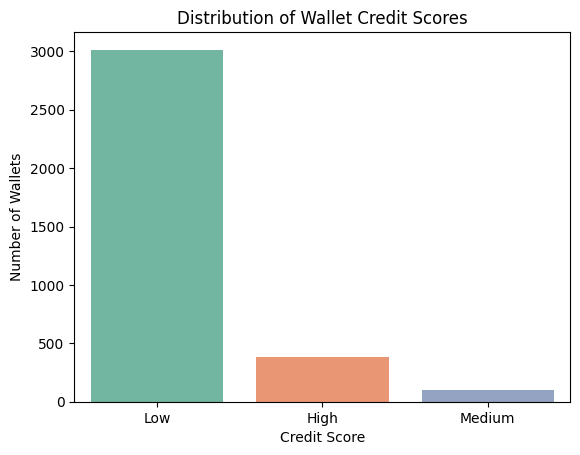

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="credit_score", data=df, palette="Set2")
plt.title("Distribution of Wallet Credit Scores")
plt.xlabel("Credit Score")
plt.ylabel("Number of Wallets")
plt.show()


In [14]:
df.groupby("credit_score")[["total_borrow_usd", "repay_ratio", "num_liquidations"]].median()


,total_borrow_usd,repay_ratio,num_liquidations
credit_score,,,
High,1.093882e+15,1.000000,0.0
Low,0.000000e+00,0.000000,0.0
Medium,8.842300e+14,0.877519,0.0


In [15]:
df.to_csv("wallet_credit_scores.csv", index=False)


In [25]:
import os
project_path = "/content/drive/MyDrive/AaveAssignment"
print(os.listdir(project_path))


['Untitled0.ipynb', 'user-wallet-transactions.json']


In [26]:
readme_path = os.path.join(project_path, "README.md")
analysis_path = os.path.join(project_path, "analysis.md")

# Create files if not already present
for path in [readme_path, analysis_path]:
    if not os.path.exists(path):
        with open(path, 'w') as f:
            f.write("")  # Start with empty content
        print(f"Created: {path}")
    else:
        print(f"Already exists: {path}")


Created: /content/drive/MyDrive/AaveAssignment/README.md
Created: /content/drive/MyDrive/AaveAssignment/analysis.md


In [27]:
os.listdir(project_path)


['Untitled0.ipynb',
 'user-wallet-transactions.json',
 'README.md',
 'analysis.md']